# Import Modules

In [3]:
# fix division
from __future__ import division
from IPython.html import widgets

# load required modules~
from ldm.settings import *

In [139]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# Settings

## Paths

In [223]:
# (1) select experiment
# basepath   = r'/home/rhopf/temp/raphi/M_EB_FM457_0_testday2_sp1_test1/'
basepath   = r'/media/rhopf/phd_backup/c_experimental_analysis/c_local_deformation_measurement/rbm_analyis/blender_project/'
exp_name   = 'specular'
prefix     = ''
ftype      = 'bmp'

# (2) path to save analysis files into
savepath = os.path.join(os.sep.join(basepath.split(os.sep)[:-1]), 'analysis')

# (3) analysis suffix
aran_suff = ''

## Camera

In [224]:
# (4) camera settings (optional parameter for rigid body motion evaluation)
mm_per_pixel = 0.01

# (5) define x direction (vertical/horizontal) (CAREFUL THIS MIGHT BE BUGGY)
main_direction = 'vertical'

## Load the Data
Data is loaded into a Python dictionary called `exp`. The printed keys show the different variables which are loaded into the dictionary where they can be accessed accordingly.

In [225]:
# load image sequence
if prefix=='':
    frames  = glob.glob(os.path.join(basepath, exp_name, prefix + '*.' + ftype))
    numbers = np.argsort([int(os.path.basename(frame.split('.')[0])) for frame in frames])
    frames  = [frames[i] for i in numbers]

else:
    frames  = glob.glob(os.path.join(basepath, exp_name, prefix + '*.' + ftype))
    numbers = np.argsort([int(frame.split(prefix)[-1].split('.')[0]) for frame in frames])
    frames  = [frames[i] for i in numbers]

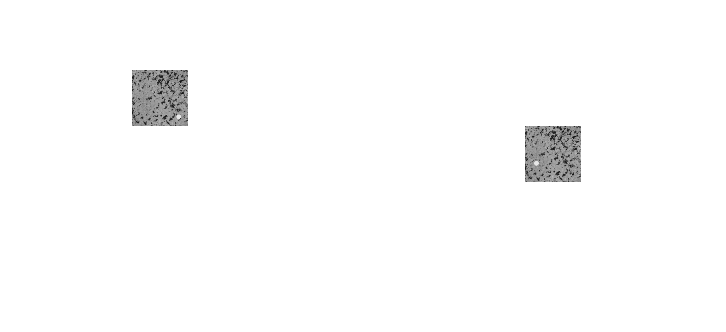

In [226]:
def crop_img(idx_img_start=0, idx_img_end=(len(frames)-1)):

    # plot it
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    img1 = plt.imread(frames[idx_img_start])
    img2 = plt.imread(frames[idx_img_end])
    plt.imshow(img1, plt.cm.Greys_r)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img2, plt.cm.Greys_r, rasterized=True)
    plt.axis('off')
    pass

w = widgets.interactive(crop_img, idx_img_start=(0, (len(frames)-1), 1), 
                                  idx_img_end=(0, (len(frames)-1), 1))
display(w)

In [227]:
# cut the file list
frames = frames[w.kwargs['idx_img_start']:w.kwargs['idx_img_end']]

In [228]:
# container to store data in
exp = {'frames':frames, 'main_direction':main_direction, 'mm_per_pixel':mm_per_pixel}

# Optical-Flow Tracking

Here, some settings for the corner detection and optical flow tracking can be modified. For the corner detection, the quality level can be adjusted between zero and one in order to increase or decrease the amount of detected points.

For the tracker, the window size determines a rectangle which is used to find the optical flow between two images. The maximum level indicates the number of pyramids (=in size reduced copies of the original image) used to track the images. This can be crucial if points between images take huge leaps at once (fast motion). However, sometimes it can happen that points completely loose their track from one image to another. The reason could be that the amount of pyramids is too big and by compressing the image, similar features further away are matched incorrectly. So it is advisable to keep this number as low as possible. For most quasi static experiments, a value of 1 or 2 seems to yield very stable results.

In [229]:
detect_features = RadioButtons(description='Use Corner Detection?', options=['Yes', 'No'])
display(detect_features)

## Setup

In [230]:
marker_mode = RadioButtons(description='Set marker creation mode:', options=[r'Rectangle', 
                                                                             r'Circle (Center/Radius)',
                                                                             r'Circle (3 Points)',
                                                                             r'Manual'])
display(marker_mode)

In [231]:
# window block size (in case of doubt the default values of 5 to 10 often provides excellent results)
block = 6

# general setup for marker creation
setup_params    = dict( m_spacing       = 2,         # only active if corner detection is deactivated
                        n_spacing       = 2,         # only active if corner detection is deactivated
                        r_scaler        = 0.8)       # radius scaling, for 3-point circles only

# parameters for Shi-Tomasi corner detection
feature_params  = dict( maxCorners   = 100000,
                        qualityLevel = 0.025,
                        minDistance  = 5,
                        blockSize    = block,)

# parameters for lucas kanade optical flow
tracker_params  = dict( winSize  = (block, block),
                        maxLevel = 1,
                        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.05))

## Select Area

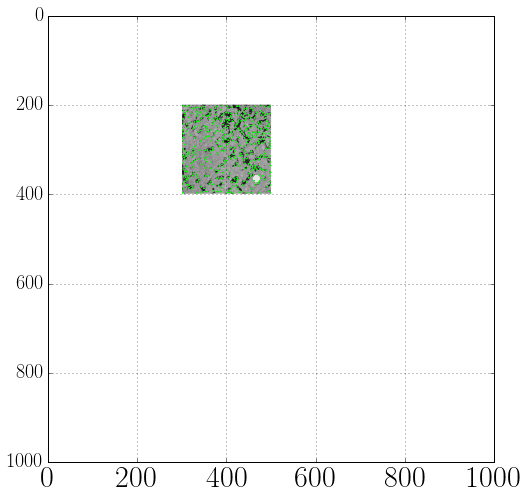

In [232]:
# ensure qt
%matplotlib qt

# update dict
setup_params['marker_mode']     = marker_mode
setup_params['detect_features'] = detect_features

marker_scaffold, img_old = ldm_trk.set_marker_area(frames, **setup_params)

# ensure inline
%matplotlib inline

p0 = ldm_trk.set_markers(marker_scaffold, frames, feature_params, **setup_params)
fig = plt.gcf()

## Run Tracking
The track coordinates are automatically saved as numpy binary array files into the corresponding directory. This way, the full tracking data can be accessed at the later point, without having to redo the tracking.

In [233]:
# trackit
coords = ldm_trk.run_tracker(frames, p0, tracker_params)

Nr. of points discarded: 65


# Postprocessing

In [245]:
# process coordinates
epsx, epsy, evecs, rb_angle, rb_transl, residuals = ldm_prc.process_coordinates(coords, main_direction, mm_per_pixel)

# add to dict
exp['epsx_loc']     = epsx
exp['epsy_loc']     = epsy

# evecs, rbm, coords, center and residuals
exp['coords']    = coords
exp['residuals'] = residuals
exp['rbm']       = dict(rot=rb_angle, transl=rb_transl)
exp['evecs']     = evecs
exp['center']    = coords.mean(axis=1)

# make a copy of exp
exp_unfiltered   = exp.copy() 

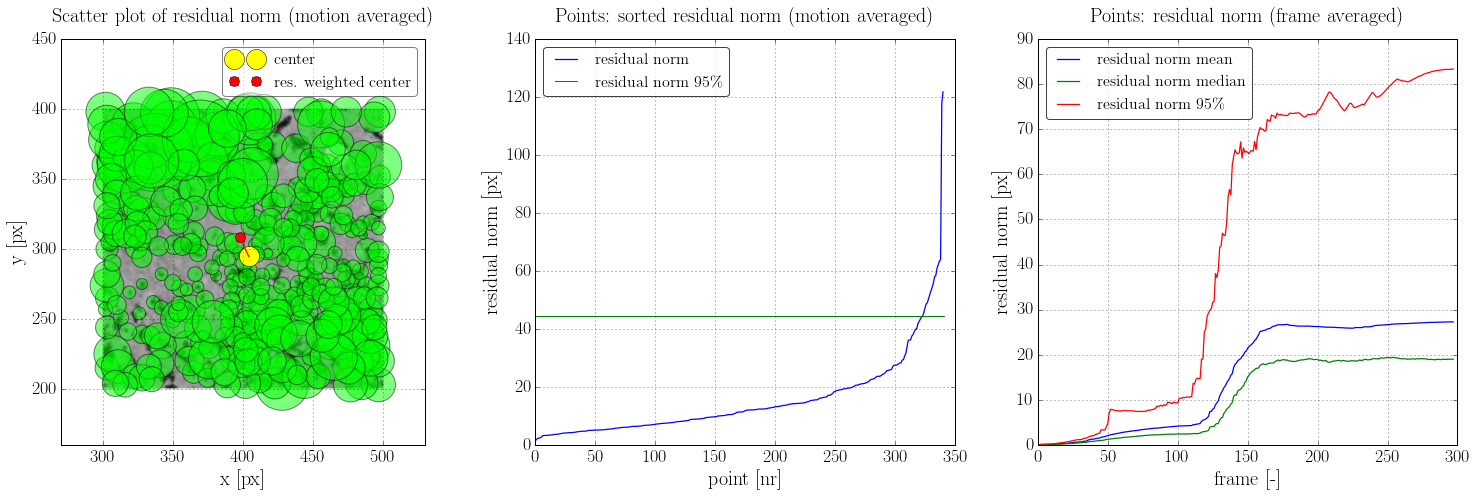

In [235]:
# check homogeneity
section = ldm_dpl.plot_homogeneity(exp_unfiltered, pct=95, pts=section)
fig = plt.gcf()
axe = plt.gca()

In [207]:
axes = fig.get_axes()

for ax in axes:
    ax.grid(None)
    ax.set_title('')
    ax.legend(fontsize=20, fancybox=True, framealpha=0.5, loc='best')
    ax.tick_params(labelsize=20)

    
axes[0].set_xlabel('x [pixel]', fontsize=24, labelpad=10)
axes[0].set_ylabel('y [pixel]', fontsize=24, labelpad=10)

axes[1].set_xlabel('point [nr.]', fontsize=24, labelpad=10)
axes[1].set_ylabel('residual norm [pixel]', fontsize=24, labelpad=10)

axes[2].set_xlabel('frame [nr.]', fontsize=24, labelpad=10)
axes[2].set_ylabel('residual norm [pixel]', fontsize=24, labelpad=10)

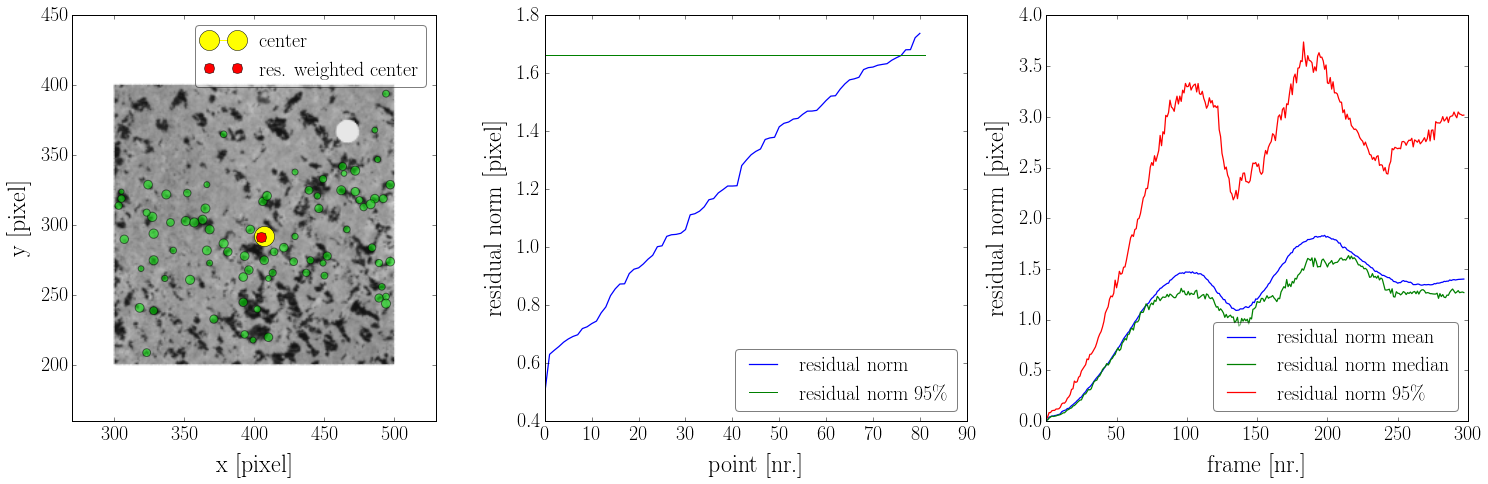

In [174]:
fig

In [175]:
#fig.savefig('/home/rhopf/Dropbox/t_thesis/report/graphics/klt_valid_rts_stats_filter.pdf', bbox_inches='tight')

## Filter Non-Homogenous Motion

**Assumption**: Affine motion dominates, such that "faulty" trackers exhibit the highest errors.

In [246]:
# percentile filtering
exp = ldm_prc.percentile_filter_coords(exp_unfiltered.copy(), level=1.5, pct=75)

Iter nr. 1 	Points deleted: 85 	Points remaining: 341 	Max. res.: 121.79 	 Global affinity: 15.125
Iter nr. 2 	Points deleted: 64 	Points remaining: 256 	Max. res.: 27.5 	 Global affinity: 4.113
Iter nr. 3 	Points deleted: 48 	Points remaining: 192 	Max. res.: 11.52 	 Global affinity: 8.04
Iter nr. 4 	Points deleted: 36 	Points remaining: 144 	Max. res.: 4.56 	 Global affinity: 2.376
Iter nr. 5 	Points deleted: 27 	Points remaining: 108 	Max. res.: 2.39 	 Global affinity: 1.694
Iter nr. 6 	Points deleted: 20 	Points remaining: 81 	Max. res.: 1.74 	 Global affinity: 2.305
Iter nr. 7 	Points deleted: 15 	Points remaining: 61 	Max. res.: 1.5 	 Global affinity: 1.262


In [247]:
section[0] = (270, 160)
section[1] = (530, 450)

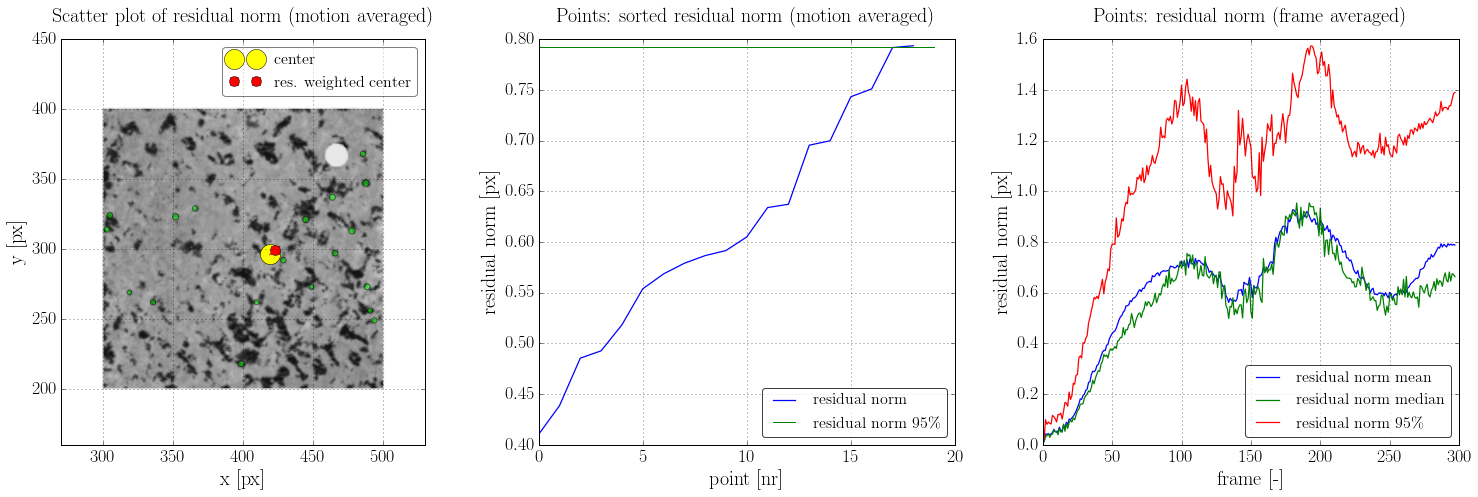

In [238]:
# check homogeneity
section = ldm_dpl.plot_homogeneity(exp, pct=95, pts=section)
fig = plt.gcf()
axe = plt.gca()

# Plotting

In [248]:
# generate "real" data
tmp = np.linspace(0, 2*np.pi, 300)
epsx_real = 0.5*(np.cos(tmp - np.pi) + 1)
epsy_real = -0.25*(np.cos(tmp - np.pi) + 1)

## Summary

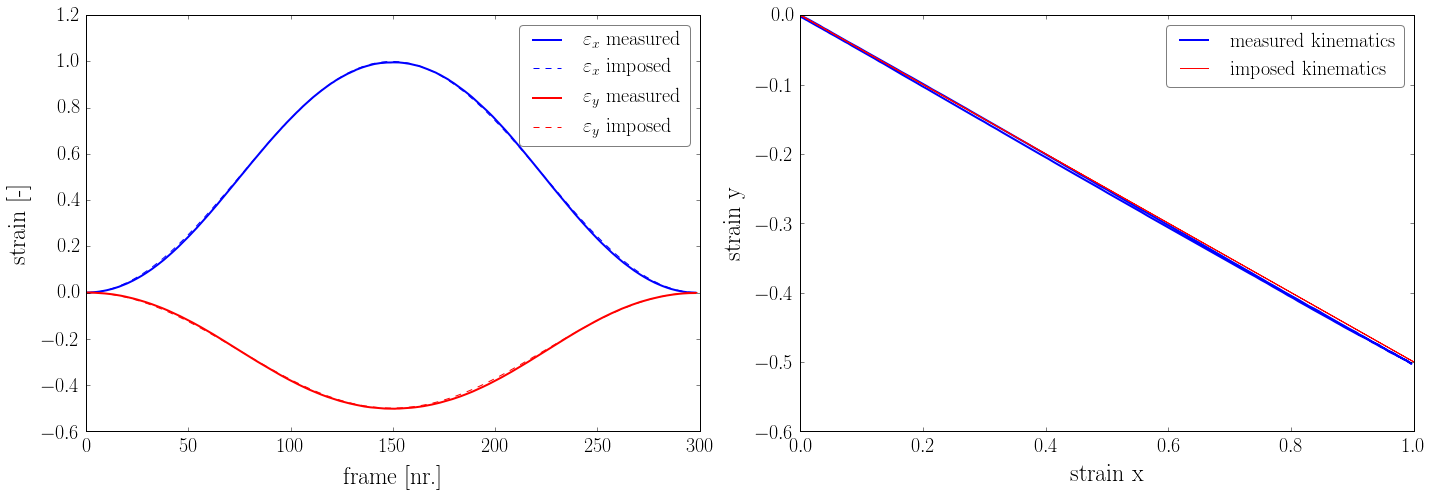

In [249]:
# plot strains
plt.figure(figsize=(20, 7))

# strains over frames
plt.subplot(1, 2, 1)
plt.plot(exp['epsx_loc'], '-b', lw=2, label=r'$\varepsilon_x$ measured')
plt.plot(epsx_real, '--b', lw=1, label=r'$\varepsilon_x$ imposed')
plt.plot(exp['epsy_loc'], '-r', lw=2, label=r'$\varepsilon_y$ measured')
plt.plot(epsy_real, '--r', lw=1, label=r'$\varepsilon_y$ imposed')
plt.legend(loc=1, fontsize=20, fancybox=True, framealpha=0.5)
# plt.title('Strains: ' + exp_name.replace('_', '\_'), fontsize=20, y=1.01)
plt.xlabel('frame [nr.]', fontsize=24, labelpad=10)
plt.ylabel('strain [-]', fontsize=24, labelpad=10)
plt.tick_params(labelsize=20, labelcolor='k')
plt.tick_params(axis='x', pad=6)
plt.tick_params(axis='y', pad=6)
plt.xlim([0, 300])
plt.ylim([-0.6, 1.2])
plt.grid(None)

# kinematics
plt.subplot(1, 2, 2)
plt.plot(exp['epsx_loc'], exp['epsy_loc'], '-b', lw=2, label='measured kinematics')
plt.plot(epsx_real, epsy_real, '-r', label='imposed kinematics')
# plt.title('Kinematics: ' + exp_name.replace('_', '\_'), fontsize=20, y=1.01)
plt.legend(loc=1, fontsize=20, fancybox=True, framealpha=0.5)
plt.xlabel('strain x', fontsize=24, labelpad=10)
plt.ylabel('strain y', fontsize=24, labelpad=10)
plt.tick_params(labelsize=20, labelcolor='k')
plt.tick_params(axis='x', pad=6)
plt.tick_params(axis='y', pad=6)
plt.xlim([0, 1])
plt.ylim([-0.6, 0])
plt.grid(None)

plt.tight_layout()
#plt.savefig('/home/rhopf/Dropbox/t_thesis/report/graphics/klt_valid_s_kinematics_filter.pdf', bbox_inches='tight')

In [222]:
exp['epsx_loc'].max()

0.99276792916042234

In [188]:
100*(1-np.max(exp['epsx_loc']))

0.39632205423465461

## Rigid Body Motion

In [184]:
tmp = np.linspace(0, np.pi,  100)
rot1 = (0.5*(np.cos(tmp)-1))*90
rot2 = ((np.sin(tmp-np.pi/2)))*90
rot3 = rot1+90

rot  = np.concatenate((rot1, rot2, rot3), axis=0)

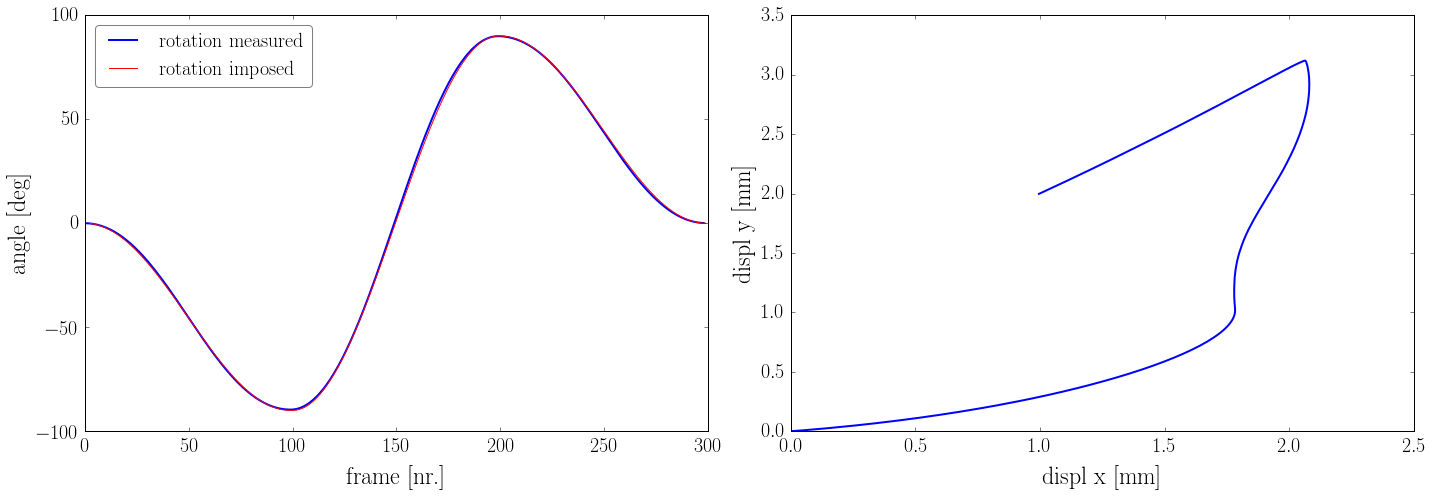

In [189]:
# plot strains
plt.figure(figsize=(20, 7))

# rotations
plt.subplot(1, 2, 1)
plt.plot(exp['rbm']['rot'], '-b', lw=2, label='rotation measured')
plt.plot(rot, '-r', lw=1, label='rotation imposed')
# plt.title('Rotations: ' + exp_name.replace('_', '\_'), fontsize=20, y=1.01)
plt.legend(loc=2, fontsize=20, fancybox=True, framealpha=0.5)
plt.xlabel('frame [nr.]', fontsize=24, labelpad=10)
plt.ylabel('angle [deg]', fontsize=24, labelpad=5)
plt.tick_params(labelsize=20, labelcolor='k')
plt.tick_params(axis='x', pad=6)
plt.tick_params(axis='y', pad=6)
plt.grid(None)

# translations
plt.subplot(1, 2, 2)
plt.plot(exp['rbm']['transl'][:, 0], exp['rbm']['transl'][:, 1], '-b', lw=2)
# plt.legend(loc='best', fontsize=18, fancybox=True, framealpha=0.5)
# plt.title('Translations: ' + exp_name.replace('_', '\_'), fontsize=20, y=1.01)
plt.xlabel('displ x [mm]', fontsize=24, labelpad=10)
plt.ylabel('displ y [mm]', fontsize=24, labelpad=5)
plt.tick_params(labelsize=20, labelcolor='k')
plt.tick_params(axis='x', pad=6)
plt.tick_params(axis='y', pad=6)
plt.grid(None)

plt.tight_layout()
#plt.savefig('/home/rhopf/Dropbox/t_thesis/report/graphics/klt_valid_rts_rbm_filter.pdf', bbox_inches='tight')

## Principal Directions

In [23]:
def plot_directions(n=0):
    
    v1, v2 = exp['evecs'][n].T
    v2     = (exp['epsx_loc'][n] + 1)*v2/2
    v1     = (exp['epsy_loc'][n] + 1)*v1/2
    fig = plt.figure(figsize=(8, 8))
    img = plt.imread(exp['frames'][n])
    plt.imshow(img, cmap=plt.cm.Greys_r, origin='lower')
    plt.quiver([exp['center'][n][0]],[exp['center'][n][1]], v1[0], v1[1], color='g', scale=3)
    plt.quiver([exp['center'][n][0]],[exp['center'][n][1]], -v1[0], -v1[1], color='g', scale=3)
    plt.quiver([exp['center'][n][0]],[exp['center'][n][1]], v2[0], v2[1], color='r', scale=3)
    plt.quiver([exp['center'][n][0]],[exp['center'][n][1]], -v2[0], -v2[1], color='r', scale=3)
    plt.xlim([1, 1000])
    plt.ylim([1, 1000])
    plt.axis('off')
    plt.tight_layout()

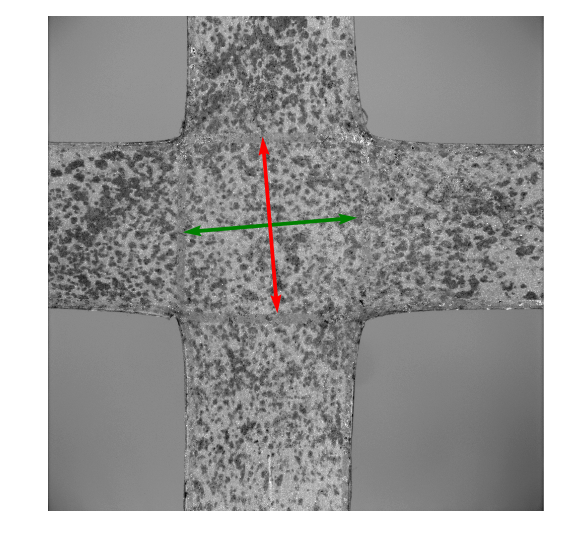

In [24]:
w = interactive(plot_directions, n=(0, len(evecs)-1, 1))
display(w)